In [1]:
import os
import configparser

# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)

insert_amd_env_vars =  int(configParser.get('COMMON', 'insert_amd_env_vars'))
HSA_OVERRIDE_GFX_VERSION =  configParser.get('COMMON', 'HSA_OVERRIDE_GFX_VERSION')
ROCM_PATH =  configParser.get('COMMON', 'ROCM_PATH')

if(insert_amd_env_vars != 0):
    os.environ["HSA_OVERRIDE_GFX_VERSION"] = HSA_OVERRIDE_GFX_VERSION
    os.environ["ROCM_PATH"] = ROCM_PATH


import subprocess
import os
import pathlib
import configparser
import sqlite3 as sl
import cv2
from pydub import AudioSegment
import math
import pickle
import shutil
import time
import multiprocessing
from multiprocessing import Process,Queue
import itertools
from threading import Thread
import soundfile as sf
from deepface import DeepFace
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


start_time = time.time()    # To measure execution time in seconds


print("PLEASE EDIT configuration.txt BEFORE EXECUTION")
print(".wav files might be generated in path. The program will automatically delete them. If execuetion stops unexpectedly, please delete them yourself")



datasetPathVideo =  configParser.get('COMMON', 'datasetPathVideo')
datasetPathAudio =  configParser.get('extractAudio', 'datasetPathAudio')
p =  configParser.get('extractAudio', 'dbChunk')
ttwbdf =  int(configParser.get('extractAudio', 'time_to_wait_before_deleting_files'))
cuda =  int(configParser.get('COMMON', 'cuda'))
cpus =  int(configParser.get('COMMON', 'cpus'))
datasetPathDatabase =  configParser.get('COMMON', 'datasetPathDatabase') + '/dataset.db'
model_weights_path =  configParser.get('train_s2fe', 'model_weights_path')

data_mean = 0.004544321005125835
data_std_dev=0.009782773269148433

# TODO dataset.db in configuration too

print("Video dataset at " + datasetPathVideo )
print("Number of cpus to use for multiprocessing : ", cpus)


  # Connection to databases
con = sl.connect(datasetPathDatabase,check_same_thread=False)
print('------------------- ABOUT TO START --------------------')

REQUIRED_SAMPLE_RATE = 16000
FACE_EMBEDDING_SIZE = 2622
AUDIO_MAX_LEN = 246000
len_to_input = int(configParser.get('train_s2fe', 'len_to_input'))
NO_OF_VIDEOS = int(configParser.get('train_s2fe', 'no_of_videos'))
validation_split = float(configParser.get('train_s2fe', 'validation_split')) 
BATCH_SIZE = int(configParser.get('train_s2fe', 'batch_size'))
EPOCH_SIZE = int(configParser.get('train_s2fe', 'epoch_size'))
save_freq = int(configParser.get('train_s2fe', 'save_freq'))
no_of_epochs = int(configParser.get('train_s2fe', 'no_of_epochs'))


def read_audio_file(file_path):
  with open(file_path, "rb") as f:
      audio_wave, sample_rate = sf.read(f)
  if sample_rate != REQUIRED_SAMPLE_RATE:
      raise ValueError(
          f"sample rate (={sample_rate}) of your files must be {REQUIRED_SAMPLE_RATE}"
      )
  return audio_wave

 
def extractAudio(row):
    absPathVideo = row[0][1]   # for this one video

    absPathAudio = y = absPathVideo.replace(datasetPathVideo,datasetPathAudio)  # for this one audio
    absPathAudio = os.path.splitext(absPathAudio)[0]
    absPathAudio_w = absPathAudio   # without the end
    absPathAudio = absPathAudio + "_audio.wav"  # full path to extracted audio from the video

    #Create Directory
    pathlib.Path(os.path.dirname(absPathAudio)).mkdir(parents=True, exist_ok=True) 

    # Extract audio monochannel and with 16khz and put it in absPathAudio
    command = "ffmpeg -nostats -loglevel 0 -y -i '" + absPathVideo + "' -acodec pcm_s16le -ab 160k -ac 1 -ar 16000 -vn '" + absPathAudio + "'"
    subprocess.call(command, shell=True)


    # Get original duration of video
    audio = AudioSegment.from_file(absPathVideo)
    audio_length_og = math.floor(audio.duration_seconds)
    #print(audio_length_og)
    


    # Will either truncate or loop the original video to reach audio_length (3,6,12 or 24)
    audio_length_list = [6,12,24]
    for audio_length in audio_length_list:
        path_var_len_audio =  absPathAudio_w + "audio" + str(audio_length) + "s.wav"    # path to the variable length audio
        path_var_len_audio_temp =  absPathAudio_w + "audio_temp" + str(audio_length) + "s.wav"  # path to a temp version of the variable length audio

        if(audio_length_og > audio_length):
            # Truncate    

            command = "ffmpeg -nostats -loglevel 0 -y -ss 0 -t "+str(audio_length)+" -i \"" + absPathAudio + "\" \"" + path_var_len_audio + "\""
            subprocess.call(command, shell=True)


        else:
            # Loop then truncaate
            #print("lesa")
            twoDigitLenStr = f"{audio_length:02}"
            #print(twoDigitLenStr)
            command = "ffmpeg -nostats -loglevel 0 -y -stream_loop -1 -i '" + absPathAudio + "' -t \"00:00:"+twoDigitLenStr+".000\" -codec:a \"aac\" -f \"wav\" -c copy '"+ path_var_len_audio_temp + "'"
            subprocess.call(command, shell=True)
            command = "ffmpeg -nostats -loglevel 0 -y -ss 0 -t "+str(audio_length)+" -i \"" + path_var_len_audio_temp + "\" \"" + path_var_len_audio + "\""
            subprocess.call(command, shell=True)



            # Will delete those files after a little bit
        ftd = [absPathAudio,path_var_len_audio,os.path.basename(path_var_len_audio),path_var_len_audio_temp]
        audio_wave = read_audio_file(path_var_len_audio)
        
        tDelete = Thread(target=delFiles, args=(ftd,))   # spawn a process
        tDelete.start()
    return audio_wave
        
           




            
# Function to delete audio temp files
def delFiles(filesToDelete):
    time.sleep(ttwbdf)  # wait a bit
    for file in filesToDelete:  
        try:
            os.remove(file)
        except OSError:
            pass
        


from random import randint
from scipy.fft import fft, ifft

def get_video(offset):
    
    try:
        #print('offset:' + str(offset))
        #print('offset:' + str(offset))
        data = con.execute("""SELECT V.ID, V.VIDEO_PATH, F.FACE_PATH FROM VIDEO V 
                        INNER JOIN FACE F ON F.ID = V.ID
                        LIMIT 1 OFFSET """ + str(offset))


        
        #print(data.fetchall())
        dataGotten = data.fetchall()
        if (len(dataGotten)) == 0:
            raise ValueError('No video was fetched')

        #print(dataGotten[0][0])
        audio_wave = extractAudio(dataGotten)
        audio_wave = audio_wave[0:len_to_input]
        audio_wave = tf.constant(audio_wave, dtype=tf.float64)

        #audio = tf.squeeze(audio_wave, axis=-1)
        fft = tf.signal.fft(
            tf.cast(tf.complex(real=audio_wave, imag=tf.zeros_like(audio_wave)), tf.complex64)
        )
        #fft = tf.expand_dims(fft, axis=-1)
        #fft = tf.squeeze(fft, axis=1)
        #print()
        fft = fft[0:(audio_wave.shape[0] // 2)]
        fft = tf.math.abs(fft)
        #fft = tf.expand_dims(fft, axis=-1)

        embedding_objs = DeepFace.represent(dataGotten[0][2],enforce_detection=False)

            
        embedding_objs = embedding_objs[0]['embedding']
        embedding_objs = np.array(embedding_objs)
        
        embedding_objs = (embedding_objs - data_mean) / data_std_dev  # Z-score normalization

        return fft,tf.constant(embedding_objs, dtype=tf.float32)
    except Exception as e:
        print('Error getting video, retrying ...:' + str(offset))
        return get_video(randint(1, NO_OF_VIDEOS - 1))


    








2024-03-19 15:11:09.581396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 15:11:09.650028: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


PLEASE EDIT configuration.txt BEFORE EXECUTION
.wav files might be generated in path. The program will automatically delete them. If execuetion stops unexpectedly, please delete them yourself
Video dataset at /media/gamal/Passport/Datasets/VoxCeleb2/Voxceleb2Video
Number of cpus to use for multiprocessing :  8
------------------- ABOUT TO START --------------------


2024-03-19 15:11:11.020986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-19 15:11:11.045799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-19 15:11:11.045978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import numpy as np
#np.set_printoptions(threshold=1000000)
v = get_video(1)

2024-03-19 15:11:11.389388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-19 15:11:11.389609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-19 15:11:11.389724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-19 15:11:11.957053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-19 15:11:11.957243: I tensorflow/compiler/xla/stream_executo

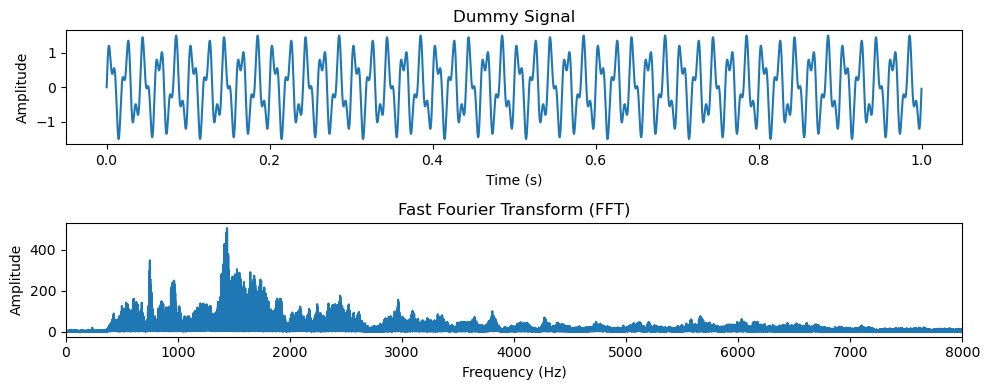

In [3]:
freqs = np.fft.fftfreq(len(v[0].numpy()), 1/REQUIRED_SAMPLE_RATE)  # Frequency axis
import matplotlib.pyplot as plt
# Plot the original signal

t = np.linspace(0, 1, REQUIRED_SAMPLE_RATE, endpoint=False)  # Time array
x = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)  # Signal

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(t, x)
plt.title('Dummy Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(v[0].numpy()))  # Plot only positive frequencies
plt.title('Fast Fourier Transform (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, REQUIRED_SAMPLE_RATE//2)  # Limit x-axis to positive frequencies
plt.tight_layout()
plt.show()

In [4]:
import numpy as np

def valid_generator(n):

    
    n =  int(NO_OF_VIDEOS * (1-validation_split))
    # initialize counter
    value = -1

    
    result_array = np.arange(n, NO_OF_VIDEOS)
    np.random.shuffle(result_array)

    # loop until counter is less than n
    while value < len(result_array) - 1:
        #print(value)
        #print(len(result_array))
        value = value + 1
        yield get_video(result_array[value])


def data_generator(n):
    result_array = np.arange(0, n)
    n =  int(NO_OF_VIDEOS * (1-validation_split))
    # initialize counter
    value = -1

    
    
    np.random.shuffle(result_array)

    # loop until counter is less than n
    while value < len(result_array) - 1:
        #print(value)
        #print(n)
        value = value + 1
        #print(len(result_array) - 1)
        #print(value)
        yield get_video(result_array[value])

        # increment the counter
        
        



for x in valid_generator(20):
    print(x)

cloned_models = [tf.keras.models.clone_model(model) for _ in range(2622)]

#from gradient_accumulator import GradientAccumulateOptimizer
#LEARNING_RATE = 0.0001
#loss_fn = tf.keras.losses.MeanSquaredError()
#optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

for model in cloned_models:
    LEARNING_RATE = 0.0001
    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
    model.compile(optimizer, loss=loss_fn)



for index,model in enumerate(cloned_models):
    try:
        model.load_weights(model_weights_path + str(index) +'.ckpt')
        print('Loaded weights')
    except:
        print('Could not load weights, using random ones.')

In [5]:
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath= model_weights_path,
#    save_weights_only=True,
#    save_freq = save_freq,

#    )


bb = get_video(5)
print(bb[1])
prediction = []
for index,model in enumerate(cloned_models):
    print(index)
    prediction.extend(model.predict(tf.expand_dims(bb[0], axis=0)).tolist())
print((np.array(prediction) * data_std_dev) + data_mean)

In [6]:
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs",update_freq="batch")

In [7]:
batches = 1000
import gc
from IPython.display import clear_output
LEARNING_RATE = 0.0001
pre_clone_weights = None

#cloned_models = [tf.keras.models.clone_model(model) for _ in range(2622)]


stacked_data_x = None
stacked_data_y = None
count_g = 0
for data in data_generator(EPOCH_SIZE):
    count_g = count_g + 1
    if(not count_g % 100):
        clear_output(wait=False)
        print("Got datapoint no: " + str(count_g))
    data_x = data[0]
    data_y = data[1]
    if stacked_data_x is None:
        stacked_data_x = data_x
        stacked_data_y = data_y
    else:
        try:
            stacked_data_x = tf.stack([stacked_data_x, data_x],axis= 0)
            stacked_data_y = tf.stack([stacked_data_y, data_y], axis= 0)
        except:
            data_x = tf.expand_dims( data[0],axis=0)
            data_y = tf.expand_dims( data[1],axis=0)
            stacked_data_x = tf.concat([stacked_data_x, data_x],axis=0)
            stacked_data_y = tf.concat([stacked_data_y, data_y],axis=0)
        #print(stacked_data_x.shape)
            


Got datapoint no: 100


In [19]:


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

X_train, X_test, y_train, y_test = train_test_split(stacked_data_x.numpy()[:, :24], 
                                                    stacked_data_y.numpy()[:, :24], 
                                                    test_size=0.01, random_state=42)

# Initialize and train the random forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, 
                                     n_jobs=-1, verbose =1, max_depth=100)
#odel = MultiOutputRegressor(rf_regressor)
#rf_regressor = RandomForestRegressor(verbose =1, max_depth=2)
rf_regressor = MultiOutputRegressor(rf_regressor)
rf_regressor.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
    
        #tf.reset_default_graph()
#for index,model in enumerate(cloned_models):
#history_model = model.fit(train_dataset
#                          , epochs=no_of_epochs,
#                          callbacks=[model_checkpoint_callback],
#                          )


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished


KeyboardInterrupt: 

In [17]:
print(y_test)
print(y_pred)

[[ 1.297213    1.6568799   0.76571506  0.20519873 -0.08313082  0.51326233
   0.47066385  0.2740276   1.1999085   0.3935111   1.6889936   0.5758279
   1.5391887   0.1162558   0.72861695  1.1668814   0.3657385   0.03231996
  -0.45437887  1.15186     1.3939674  -0.46766028 -0.6026386   0.6183309 ]]
[[ 1.04905124  0.4472841   1.06397689  0.82906844 -0.12448086  0.67541213
   0.99226976  1.09436884  0.83481417  0.86195271  2.48018005  0.53243846
   2.19899467  1.27885776  0.81941429  0.15844889  1.04486336  0.67198703
   0.76501501  1.40585426  1.46888     0.57200855 -0.35794425  0.89995224]]
